PIL 은 Python Imaging Library 의 패키지 이름으로 간단한 이미지 처리를 할 수 있도록 도와줍니다. 버전이 맞지 않으면 몇몇 기능이 실행되지 않으니 반드시 버전을 확인합니다.

In [1]:
import PIL
import skimage

print(f'PIL=={PIL.__version__}')
print(f'scikit-image=={skimage.__version__}')

PIL==5.3.0
scikit-image==0.16.2


`image_path` 의 JPG 이미지 파일을 PIL 을 이용하여 로딩합니다. 타입은 JpegImageFile 입니다. IPython notebook 에서 이미지를 실행하면 해당 이미지가 output cell 에 출력됩니다.

type of `image` = <class 'PIL.JpegImagePlugin.JpegImageFile'>


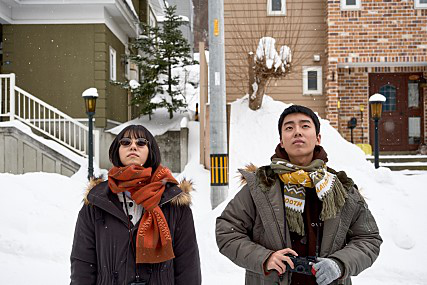

In [2]:
from PIL import Image

image_path = './data/2018_A.jpg'
image = Image.open(image_path)

print(f'type of `image` = {type(image)}')
image

우리는 이러한 여러 이미지들을 dense matrix 로 변환한 뒤 모델링 작업에 이용할 것입니다. 이미지는 RGB 세 가지 색상으로 이뤄진 tensor 로 생각할 수 있습니다. numpy 는 image 를 곧바로 numpy.ndarray 로 처리해줍니다. 이 이미지는 height=285, width=427 의 3색 이미지입니다.

In [3]:
import numpy as np

X = np.array(image)
print(f'shape of `X` = {X.shape}')

shape of `X` = (285, 427, 3)


tensor 의 첫번째 값만을 취하면 R 에 해당하는 값들로 구성된 shape = (285, 427) 의 numpy.ndarray 가 만들어집니다. 이를 `PIL.Image.fromarray()` 에 다시 입력하면 흑백 이미지로 변환하여 보여줍니다. PIL 은 tensor 가 아닌 matrix 형식의 numpy.ndarray 가 입력되면 이를 흑백 이미지로 취급합니다.

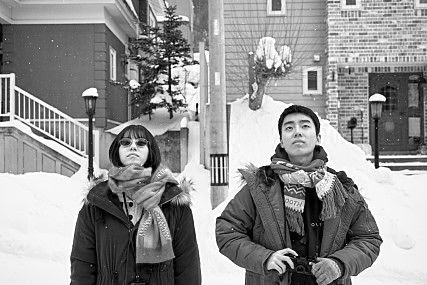

In [4]:
Image.fromarray(X[:,:,0])

그렇기 때문에 B 에 해당하는 3번째 값들을 이용하여 흑백이미지를 만들면 그 결과가 조금 다릅니다. 칼라 이미지는 R + G + B 이니까요.

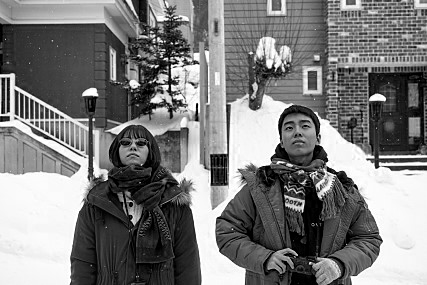

In [5]:
Image.fromarray(X[:,:,2])

우리가 이용할 모델들은 주로 이미지의 크기가 동일하다고 가정하는 경우들이 많습니다. 그렇게 가정해야 mini-batch style 로 처리하기 용이하기 때문입니다. Image 의 크기를 조절하기 위한 간단한 방법으로 scikit-image 의 `skimage.transform.resize()` 함수를 이용할 수 있습니다. 그런데 `resize()` 함수의 input 과 output 의 data type 이 각각 uint8 과 float64 로 다릅니다. 실제로 `X` 의 일부값을 출력하면 그 값들이 정수이지만, `X_resize` 의 값은 1 보다 작은 소수입니다.

`resize()` 함수는 모든 값을 0 ~ 1 사이로 변환한 뒤, 크기가 줄어들 경우 인접한 pixel 이 평균값을, 크기가 커질 경우 적절히 새로운 칸의 색을 추가합니다. 그리고 data type `uint8` 은 8bit 의 부호가 없는 정수 (0 보다 큰 정수)를 의미합니다. 이 값의 범위는 [0, 2^8-1] = [0, 255] 입니다. 

In [6]:
from skimage.transform import resize

X_resize = resize(X, (100, 200))

print(f'shape of `X_resize` : {X_resize.shape}')
print(f'dtpye of `X`        : {X.dtype}')
print(f'dtype of `X_resize` : {X_resize.dtype}')

print('\nsample of `X[:3,:3,]`')
print(X[:3,:3,0])

print('\nsample of `X_resize[:3,:3,]`')
print(X_resize[:3,:3,0])

shape of `X_resize` : (100, 200, 3)
dtpye of `X`        : uint8
dtype of `X_resize` : float64

sample of `X[:3,:3,]`
[[130 131 141]
 [130 125 128]
 [134 125 124]]

sample of `X_resize[:3,:3,]`
[[0.50159828 0.51523603 0.54406863]
 [0.52743064 0.50763946 0.49471324]
 [0.56952941 0.54315319 0.51882966]]


그렇기 때문에 resize 한 이미지를 실제 이미지처럼 확인하기 위해서는 이를 uint8 형식으로 re-scaling 해야 합니다. 간단한 방법으로 `X_resize` 에 255 를 곱한다음, 정수로 casting 을 합니다.

In [7]:
X_resize_ = np.array(255 * X_resize, dtype=np.uint8)

print(f'dtype of X_resized_ = {X_resize_.dtype}')
print('\nsample of `X_resize_[:3,:3,]`')
print(X_resize_[:3,:3,0])

dtype of X_resized_ = uint8

sample of `X_resize_[:3,:3,]`
[[127 131 138]
 [134 129 126]
 [145 138 132]]


다시 확인하니 위아래로 눌린 조그마한 이미지가 출력됩니다.

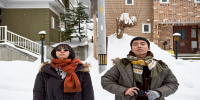

In [8]:
Image.fromarray(X_resize_)

이러한 과정이 반복될테니 이미지의 크기를 조절한 다음, 이를 uint8 형식으로 변환하는 과정을 함수로 만들면 편할 듯 합니다.

dtype of `X_large` = uint8
shape of `X_large` = (600, 900, 3)


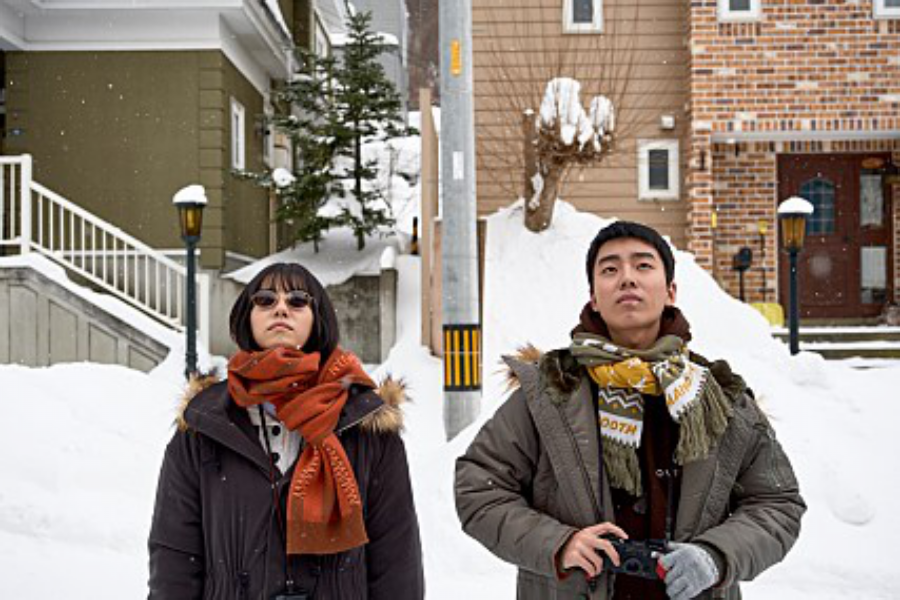

In [9]:
def resize_image_array(X, height=100, width=200):
    X_ = resize(X, (height, width))
    X_ = np.array(255 * X_, dtype=np.uint8)
    return X_

X_large = resize_image_array(X, height=600, width=900)

print(f'dtype of `X_large` = {X_large.dtype}')
print(f'shape of `X_large` = {X_large.shape}')
Image.fromarray(X_large)

이렇게 만들어진 이미지 혹은 numpy.ndarray 는 Image 의 save 함수를 이용하여 저장할 수 있습니다. Positional argument 의 첫번째는 이미지의 파일 주소, 그 다음은 이미지 저장 포멧, 그 외에는 저장에 관련된 여러 옵션이 keyword arguments 로 설정되어 있습니다.

In [10]:
image_large = Image.fromarray(X_large)
image_large.save('./data/enlarge_image.jpg', format='JPEG', quality=120)

그런데 feed forward neural network 는 input 으로 column vector 를 입력받습니다. 하지만 이미지는 matrix 형식입니다. flatten 은 각 row 를 순차적으로 이어붙이는 함수입니다. (100, 200, 3) 크기의 tensor 를 flatten 하면 100 x 200 x 3 = 60000 차원의 벡터가 만들어집니다. 이를 다시 이미지로 복원할 수도 있습니다.

In [11]:
image_vec = X_resize_.flatten()
X_recovered = image_vec.reshape(X_resize_.shape[0], -1, 3)

print(f'original   shape = {X_resize_.shape}')
print(f'flatten    shape = {image_vec.shape}')
print(f'recovered  shape = {X_recovered.shape}')

original   shape = (100, 200, 3)
flatten    shape = (60000,)
recovered  shape = (100, 200, 3)


reshape 함수를 이용하기 때문에 tensor 의 첫번째 차원, 세번째 차원의 크기만 정의해도 두번째 차원의 크기는 맞추기 때문에 이미지가 제대로 복원됩니다.

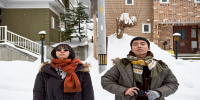

In [12]:
Image.fromarray(X_recovered)

flatten 의 순서는 아래의 함수를 통하여 확인할 수 있습니다.

In [13]:
indices = np.arange(9)
print(indices)

[0 1 2 3 4 5 6 7 8]


In [14]:
indices.reshape(3,3)

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [15]:
indices.reshape(3,3).flatten()

array([0, 1, 2, 3, 4, 5, 6, 7, 8])